# Modeling

The goal of this project is to beat the baseline accuracy while attaining as high of a sensitivity score as possible. As such, the three models built in this notebook are scored on accuracy and sensitivity and compared to the baseline accuracy for each image. None of the three models improved on the baseline accuracy score for either the training or test image. Additionally, all models returned a sensitivity score of 0 for the test image. The baseline accuracies for the training and testing images are 97.81% and 98.42, respectively.

The three models trained are as follows: k-means (unsupervised), multi-layer perception (supervised), and support vector classifier (supervised). The training and testing images each consist of 294,848 pixels.

In [270]:
from PIL import Image, ImageChops
import skimage
from skimage import io
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pandas as pd

In [271]:
# Functions for processing the .png files

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

    
def open_trim_save(inFile, outFile):
    im = Image.open(inFile)
    im = trim(im)
    im.save(outFile)
    
    
def process_file(file):
    img = io.imread(base_path + file)
    rows, cols, bands = img.shape
    X = img.reshape(rows*cols, bands)

    return img, X

In [272]:
# Trim white border from images
base_path = './training_data/training_images/'

open_trim_save(base_path + 'Base_tile.png', base_path + 'Base_tile_trimmed.png')
open_trim_save(base_path + 'Base_tile_validation.png', base_path + 'Base_tile_validation_trimmed.png')
open_trim_save(base_path + 'Labaled_tile.png', base_path + 'Labeled_tile_trimmed.png')
open_trim_save(base_path + 'Labeled_tile_validation.png', base_path + 'Labeled_tile_validation_trimmed.png')

In [273]:
# Set global variables

base_path = './training_data/training_images/'
classes = {'vacant_building': 2, 'building':1, 'anything_else': 0}
n_classes = len(classes)
palette = np.uint8([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
files = dict(file = 'Labeled_tile_trimmed.png',
             file_unlabeled = 'Base_tile_trimmed.png',
             file_2 = 'Labeled_tile_validation_trimmed.png',
             file_2_unlabeled = 'Base_tile_validation_trimmed.png'
            )

## Define Features and Labels

In [274]:
# Create X variables and images

img_labeled, X_labeled = process_file(files['file'])
img_unlabeled, X_unlabeled = process_file(files['file_unlabeled'])
img_2_labeled, X_2_labeled = process_file(files['file_2'])
img_2_unlabeled, X_2_unlabeled = process_file(files['file_2_unlabeled'])

In [275]:
# Create Y variables

red = [255, 0, 0, 255]

Y_1 = [(pixel == red).all() for pixel in X_labeled]
Y_2 = [(pixel == red).all() for pixel in X_2_labeled]

## Baseline Scores

In [276]:
def sensitivity_score(Y, preds):
    Y_idx = [idx for idx, pixel in enumerate(Y) if pixel == True]
    preds_idx = [idx for idx, pixel in enumerate(preds) if pixel == True]
    
    count_correct = 0
    for pred in preds_idx:
        if pred in Y_idx:
            count_correct += 1
    
    total_abandoned = sum(Y)
    
    return count_correct / total_abandoned

def accuracy_score(Y, preds):
    predicted_abandoned = preds == 1
    acc = sum(predicted_abandoned == Y) / len(predicted_abandoned)
    return acc

In [277]:
# Determine baseline scores

num_abandoned_pixels_1 = sum(Y_1)
num_abandoned_pixels_2 = sum(Y_2)

total_pixels_1 = len(Y_1)
total_pixels_2 = len(Y_2)

baseline_acc_1 = 1 - (num_abandoned_pixels_1 / total_pixels_1)
baseline_acc_2 = 1 - (num_abandoned_pixels_2 / total_pixels_2)

In [278]:
print('The baseline accuracy for image 1:', baseline_acc_1)
print('The baseline accuracy for image 2:', baseline_acc_2)

The baseline accuracy for image 1: 0.9780700564358584
The baseline accuracy for image 2: 0.9842461200347298


## Tile 1 - Training

### Display the labeled tile

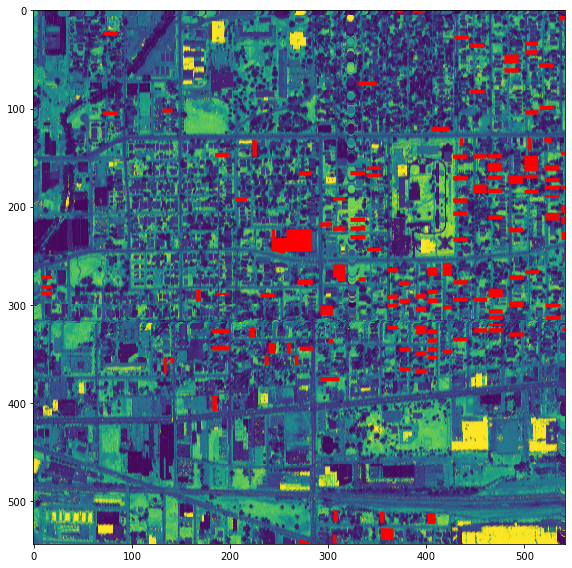

In [279]:
plt.figure(figsize = (8,8))
io.imshow(img_labeled);

### Fit a k-means clustering model

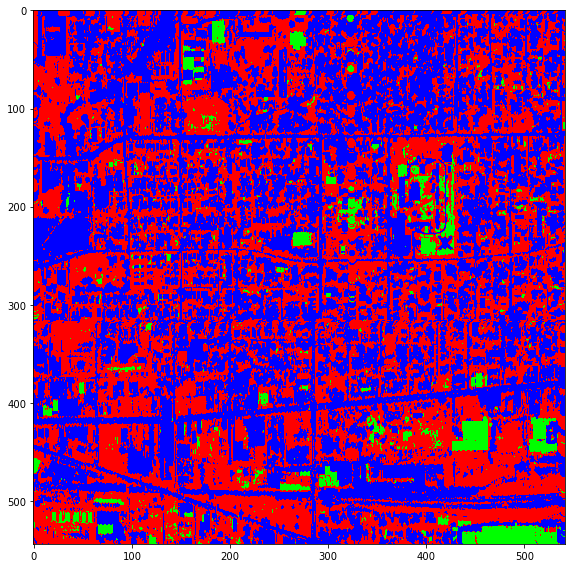

In [310]:
kmeans = KMeans(n_clusters=n_classes, random_state=3).fit(X_unlabeled)

unsupervised = kmeans.labels_.reshape(rows, cols)

plt.figure(figsize = (8,8))
io.imshow(palette[unsupervised]);

In [288]:
# Training Scores

acc = accuracy_score(Y_1, kmeans.labels_)
sens = sensitivity_score(Y_1, kmeans.labels_)

print('Accuracy:', acc)
print('Sensitivity:', sens)

Accuracy: 0.9396706099413935
Sensitivity: 0.0474791215589236


## Tile 2 - Testing

### Display the labeled tile

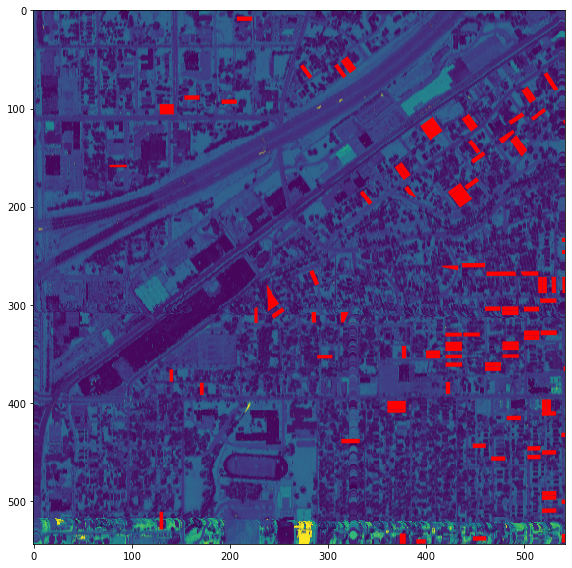

In [264]:
plt.figure(figsize = (8,8))
io.imshow(img_2_labeled);

### Make predictions

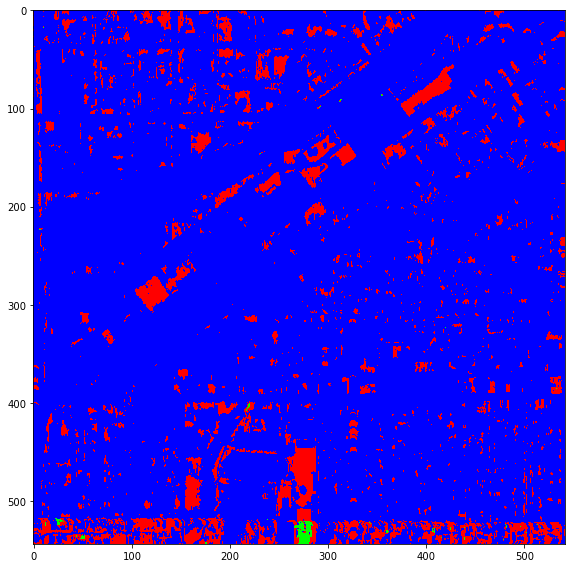

In [291]:
preds = kmeans.predict(X_2_unlabeled)

unsupervised = preds.reshape(rows, cols)

plt.figure(figsize = (8,8))
io.imshow(palette[unsupervised]);

In [292]:
# Scores

acc = accuracy_score(Y_2, preds)
sens = sensitivity_score(Y_2, preds)

print('Accuracy:', acc)
print('Sensitivity:', sens)

Accuracy: 0.9828827056652919
Sensitivity: 0.0


---

## Supervised models

#### MLP Classifier

In [305]:
# Multi Layer Perception Classifier neural network
clf_mlp = MLPClassifier(solver='lbfgs',
                    alpha=1e-5,
                    hidden_layer_sizes=(5, 2),
                    random_state=1)

clf_mlp.fit(X_unlabeled, Y_1)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [306]:
# Training Scores

acc = accuracy_score(Y_1, clf_mlp.predict(X_unlabeled))
sens = sensitivity_score(Y_1, clf_mlp.predict(X_unlabeled))

print('Accuracy:', acc)
print('Sensitivity:', sens)

Accuracy: 0.9780700564358584
Sensitivity: 0.0


In [307]:
# Testing Scores

acc = accuracy_score(Y_2, clf_mlp.predict(X_2_unlabeled))
sens = sensitivity_score(Y_2, clf_mlp.predict(X_2_unlabeled))

print('Accuracy:', acc)
print('Sensitivity:', sens)

Accuracy: 0.9842461200347298
Sensitivity: 0.0


#### SVM

In [293]:
# Support Vector Classifier

clf = SVC(gamma='auto')
clf.fit(X_unlabeled, Y_1)

preds = clf.predict(X_unlabeled)

In [297]:
# Training Scores

acc = accuracy_score(Y_1, preds)
sens = sensitivity_score(Y_1, preds)

print('Accuracy:', acc)
print('Sensitivity:', sens)

Accuracy: 0.9781277132624268
Sensitivity: 0.002629137024435509


In [303]:
print(sum(preds), 'pixels predicted as abandoned.')
print(sum((preds == 1) & Y_1), 'pixels correctly predicted as abandoned.')

print('0 False positives.')

17 pixels predicted as abandoned.
17 pixels correctly predicted as abandoned.
0 False positives.


In [308]:
# Testing Scores
preds_test = clf.predict(X_2_unlabeled)

acc = accuracy_score(Y_1, preds_test)
sens = sensitivity_score(Y_1, preds_test)

print('Accuracy:', acc)
print('Sensitivity:', sens)

Accuracy: 0.9780700564358584
Sensitivity: 0.0
